# Momentum Backprop

### Discussion on the momentum and test set


Momentum helps smooth out oscillations near a minimum, especially when the Hessian has high curvature (large eigenvalue) in one direction and low curvature in another. But the point is that this is for the weight contour (W1(1,1) vs W2(1,1), for example), not the function itself. So we have to find a function that creates such weights so that the usefulness of momentum can be shown.
Honestly, I played around with different functions, and after exploring various ones, I came across this function: ( f(x) = 100x^4 + x^2 ) over (-1) to (1).
Near (x = 0), the (x^2) term dominates, whereas farther away from (x = 0), the (100x^4) term dominates. So there might be a chance that gradients explode if the learning rate is high and it overshoots, and near the minimum, the gradient vanishes. Maybe momentum can smooth this transition.

Regarding the exploding issue, I even encountered overflow (overflow of gradient norm) during training with high learning rates because of the overshooting problem. However, I am not sure whether this is the only reason. Otherwise, I reduced the learning rate, and adding momentum seemed to make the situation better.

W1 shape: (20, 1), b1 shape: (20, 1), W2 shape: (1, 20), b2 shape: (1, 1)
Final grad norm 391.7178537179924


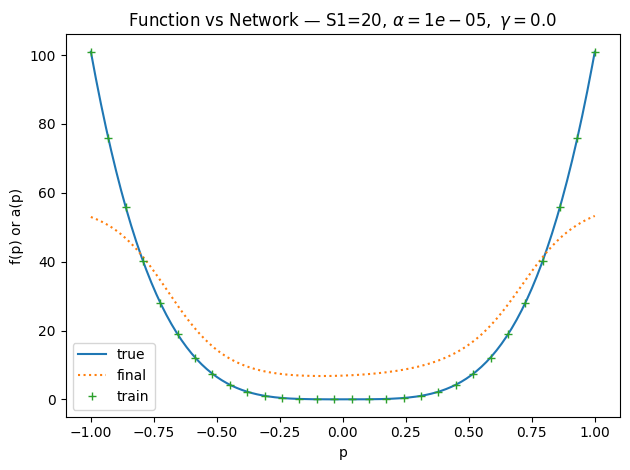

W1 shape: (20, 1), b1 shape: (20, 1), W2 shape: (1, 20), b2 shape: (1, 1)
Final grad norm 390.9474080541784


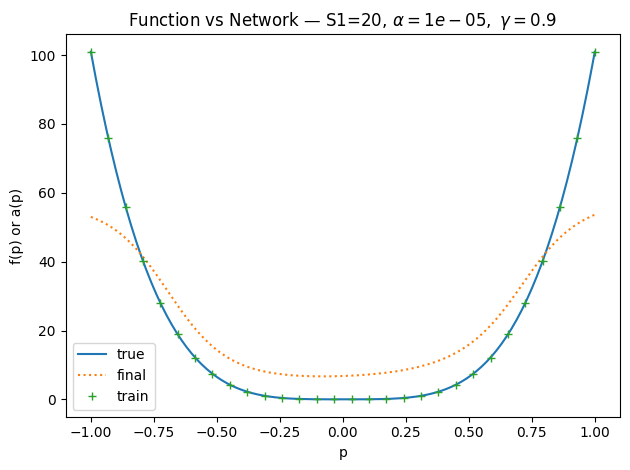

W1 shape: (20, 1), b1 shape: (20, 1), W2 shape: (1, 20), b2 shape: (1, 1)
Final grad norm 349.9067665303294


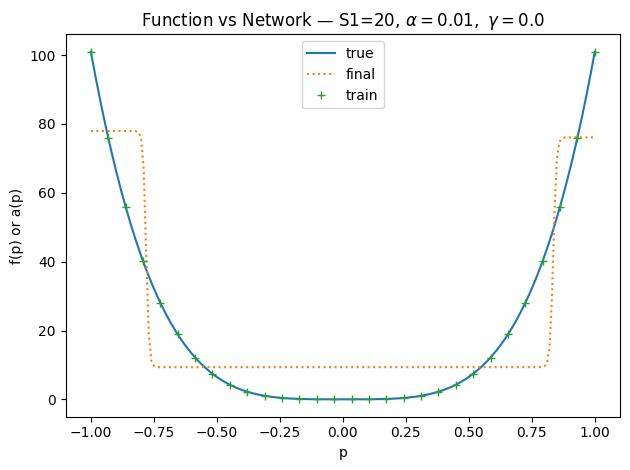

W1 shape: (20, 1), b1 shape: (20, 1), W2 shape: (1, 20), b2 shape: (1, 1)
Final grad norm 0.01795043289402186


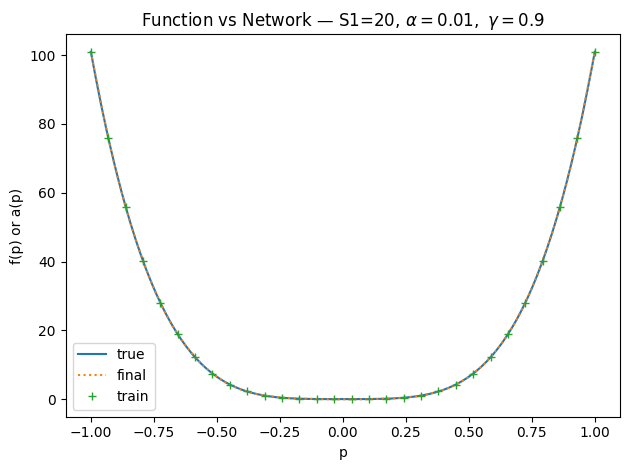

W1 shape: (20, 1), b1 shape: (20, 1), W2 shape: (1, 20), b2 shape: (1, 1)


/tmp/ipykernel_401029/2188622566.py:7: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+np.exp(-x))


Final grad norm 467.25273119085966


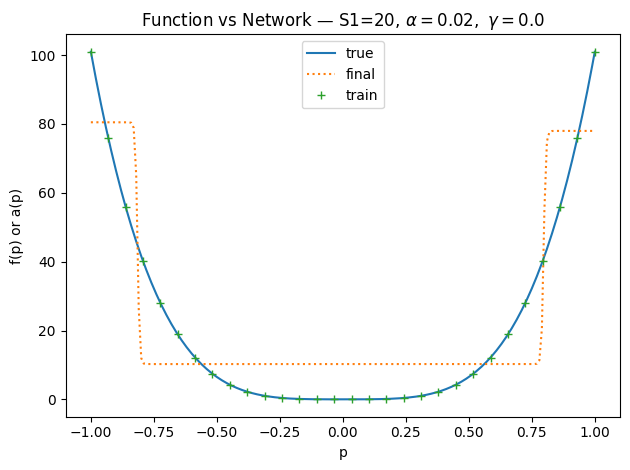

W1 shape: (20, 1), b1 shape: (20, 1), W2 shape: (1, 20), b2 shape: (1, 1)
Final grad norm 0.01285801045222873


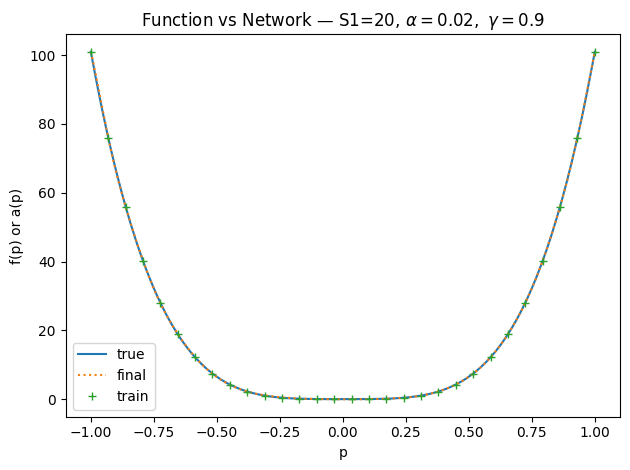

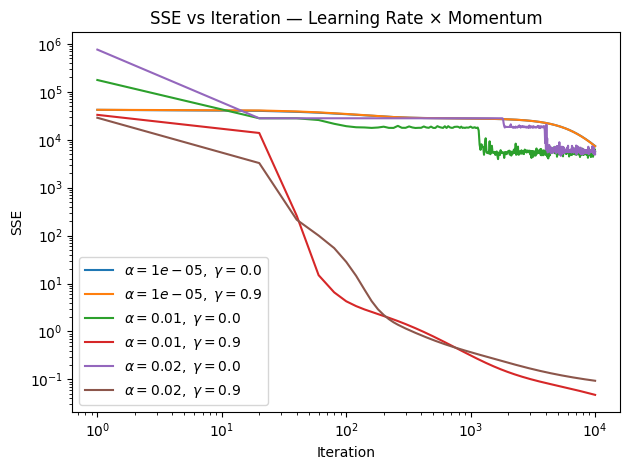

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)

def logsig(x):
    return 1.0/(1.0+np.exp(-x))

def dlogsig(a):
    return a*(1.0-a)

def f1(p):
    x = p[0]
    # return (0.6*np.sin(np.pi*x)+2*np.cos(np.pi*x**2)).reshape(1,-1)
    # return (1.6*np.sin(np.pi*x)+10*np.cos(np.pi*x**2)).reshape(1,-1)
    return ((100*(x)**4)+(x)**2).reshape(1,-1)
    # return ((x)**2).reshape(1,-1)
    
    # return (0.6*np.sin(2*np.pi*x)*np.exp(-0.5*x**2) + 0.35*np.sin(3*x) + 0.2*x + 0.15*np.tanh(1.2*x)).reshape(1,-1)


pmin = -1
pmax = 1
P = np.linspace(pmin,pmax,30).reshape(1,-1)
# print("Training points shape:",P.shape, "P[0]",P[0],"P[0] shape:",P[0].shape)
T = f1(P)
Pfine = np.linspace(pmin,pmax,201).reshape(1,-1)
Tf = f1(Pfine)

def train_run(P,T,S1_neurons,wscale,alpha,Momentum_gamma,max_iters,grad_tol,calculate_sse_after_iteration,seed):
    rng = np.random.default_rng(seed)
    W1 = wscale*rng.standard_normal((S1_neurons,1))
    b1 = wscale*rng.standard_normal((S1_neurons,1))
    W2 = wscale*rng.standard_normal((1,S1_neurons))
    b2 = wscale*rng.standard_normal((1,1))
    mW1 = np.zeros_like(W1)
    mb1 = np.zeros_like(b1)
    mW2 = np.zeros_like(W2)
    mb2 = np.zeros_like(b2)
    iters = []
    SSEs = []
    grads = []
    mid_snap = None
    print(f"W1 shape: {W1.shape}, b1 shape: {b1.shape}, W2 shape: {W2.shape}, b2 shape: {b2.shape}")
    for k in range(1,max_iters+1):
        N1 = W1@P + b1
        A1 = logsig(N1)
        N2 = W2@A1 + b2
        A2 = N2
        E = T - A2
        S2_sensitivity = -2.0*E
        dW2 = S2_sensitivity@A1.T
        db2 = np.sum(S2_sensitivity,axis=1,keepdims=True)
        S1_sensitivity = (W2.T@S2_sensitivity)*dlogsig(A1)
        dW1 = S1_sensitivity@P.T
        db1 = np.sum(S1_sensitivity,axis=1,keepdims=True)
        # print("dW1 shape",dW1.shape,"db1",db1.shape,"dW2",dW2.shape,"db2",db2.shape)

        
        g = np.sqrt(np.sum(dW1**2)+np.sum(db1**2)+np.sum(dW2**2)+np.sum(db2**2))
        sW1 = -alpha*dW1
        sb1 = -alpha*db1
        sW2 = -alpha*dW2
        sb2 = -alpha*db2
        mW1 = Momentum_gamma*mW1 + (1-Momentum_gamma)*sW1
        mb1 = Momentum_gamma*mb1 + (1-Momentum_gamma)*sb1
        mW2 = Momentum_gamma*mW2 + (1-Momentum_gamma)*sW2
        mb2 = Momentum_gamma*mb2 + (1-Momentum_gamma)*sb2
        W1 = W1 + mW1
        b1 = b1 + mb1
        W2 = W2 + mW2
        b2 = b2 + mb2
        if k%calculate_sse_after_iteration==0 or k==1:
            A2_eval = (W2@logsig(W1@P + b1) + b2)
            # sum of squared errors (sse)
            sse = np.sum((T - A2_eval)**2)
            iters.append(k); SSEs.append(float(sse)); grads.append(float(g))
        # Saving weights value for mid snap (and final snap after for loop) for later evaluation and plotting of network output
        if mid_snap is None and k>=max_iters//2:
            mid_snap = (W1.copy(),b1.copy(),W2.copy(),b2.copy())
        if k>10 and g<grad_tol:
            if (len(iters)==0) or (iters[-1]!=k):
                A2_eval = (W2@logsig(W1@P + b1) + b2)
                sse = np.sum((T - A2_eval)**2)
                iters.append(k); SSEs.append(float(sse)); grads.append(float(g))
            break
    final_snap = (W1.copy(),b1.copy(),W2.copy(),b2.copy())
    return {"iters":iters,"SSE":SSEs,"grad":grads,"mid":mid_snap,"final":final_snap}

grad_tol = 1e-3
max_iters = 10**4
calculate_sse_after_iteration = 20

S1_ref = 20
alpha_array = [1e-5,1e-2,2e-2]
Momentum_gamma_array = [0.0,0.9]
hist_lrJ = []
labels_lrJ = []

for i,alpha in enumerate(alpha_array):
    for j,Momentum_gamma in enumerate(Momentum_gamma_array):
        h = train_run(P=P,T=T,S1_neurons=S1_ref,wscale=1,alpha=alpha,Momentum_gamma=Momentum_gamma,max_iters=max_iters,grad_tol=grad_tol,calculate_sse_after_iteration=calculate_sse_after_iteration,seed=100)
        hist_lrJ.append(h)
        labels_lrJ.append(fr"$\alpha={alpha},\ \gamma={Momentum_gamma}$")


        W1f,b1f,W2f,b2f = h["final"]
        print("Final grad norm",h["grad"][-1])
        A_final = W2f@logsig(W1f@Pfine + b1f) + b2f
        plt.figure()
        plt.plot(Pfine.ravel(),Tf.ravel(),label="true")
        plt.plot(Pfine.ravel(),A_final.ravel(),":",label="final")
        plt.plot(P.ravel(),T.ravel(),"+",label="train")
        plt.xlabel("p"); plt.ylabel("f(p) or a(p)"); plt.title(f"Function vs Network — S1=20, $\\alpha={alpha},\\ \\gamma={Momentum_gamma}$"); plt.legend();  plt.tight_layout(); plt.show()


plt.figure()
for h,l in zip(hist_lrJ,labels_lrJ):
    x = np.array(h["iters"]); y = np.clip(np.array(h["SSE"]),1e-16,None)
    plt.loglog(x,y,label=l)
plt.xlabel("Iteration"); plt.ylabel("SSE"); plt.title("SSE vs Iteration — Learning Rate × Momentum"); plt.legend(); plt.tight_layout(); plt.show()


These plots use a fixed S1 (number of neurons = 20) and a fixed number of iterations (10^4), and—more importantly—the weights are initialized from the same point (seed = 100).

α = 1e-5 (blue/orange): Steps are tiny. so progress is slow and we need more number of iterations to move in the dirction of reducing the gradients. Momentum can’t build useful velocity (gradients are small), so γ=0.9 ≈ γ=0.

γ = 0 (green/purple): Plateau. Updates overshoot; you see oscillation. Hessian matrix eigen values are like this (λ_max ≫ λ_min). 

γ = 0.9 (red/brown): Big improvement. Momentum damps the zig-zag , so SSE drops rapidly.

### impact of different number of neurons:

W1 shape: (10, 1), b1 shape: (10, 1), W2 shape: (1, 10), b2 shape: (1, 1)
W1 shape: (20, 1), b1 shape: (20, 1), W2 shape: (1, 20), b2 shape: (1, 1)
W1 shape: (30, 1), b1 shape: (30, 1), W2 shape: (1, 30), b2 shape: (1, 1)


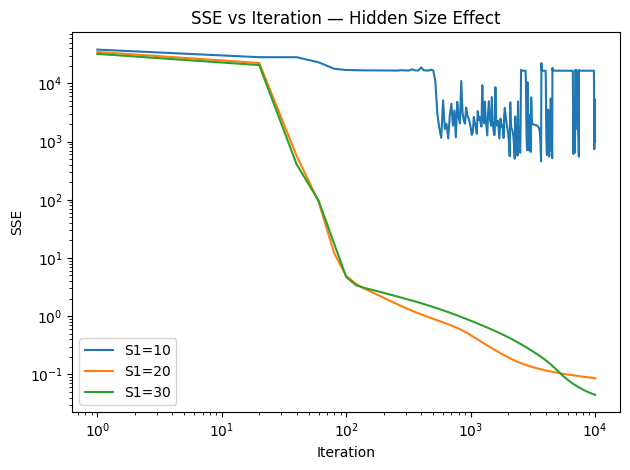

In [131]:
S1_neurons_array = [10,20,30]
# hist_S1 means history for different S1
hist_S1 = []
labels_S1 = []

for idx,S1 in enumerate(S1_neurons_array):
    h = train_run(P=P,T=T,S1_neurons=S1,wscale=0.1,alpha=0.01,Momentum_gamma=0.9,max_iters=max_iters,grad_tol=grad_tol,calculate_sse_after_iteration=calculate_sse_after_iteration,seed=200)
    hist_S1.append(h)
    labels_S1.append(f"S1={S1}")

plt.figure()
for h,l in zip(hist_S1,labels_S1):
    x = np.array(h["iters"]); y = np.clip(np.array(h["SSE"]),1e-16,None)
    plt.loglog(x,y,label=l)
plt.xlabel("Iteration"); plt.ylabel("SSE"); plt.title("SSE vs Iteration — Hidden Size Effect"); plt.legend(); plt.tight_layout(); plt.show()



Here, as we can see, as the number of neurons decreases, the oscillation becomes higher. As soon as we have enough neurons (larger than a threshold) the number of neurons does not matter after that point. One other assumption I have here is that the weights become competitive when the number of weights is limited: they change drastically to fit the function as the gradient changes drastically. Therefore, even with large γ= 0.9, the sensitivities become large enough to dominate delta W. Please correct me if I am wrong.

### impact of different weight initialization:

W1 shape: (30, 1), b1 shape: (30, 1), W2 shape: (1, 30), b2 shape: (1, 1)
W1 shape: (30, 1), b1 shape: (30, 1), W2 shape: (1, 30), b2 shape: (1, 1)
W1 shape: (30, 1), b1 shape: (30, 1), W2 shape: (1, 30), b2 shape: (1, 1)
W1 shape: (30, 1), b1 shape: (30, 1), W2 shape: (1, 30), b2 shape: (1, 1)


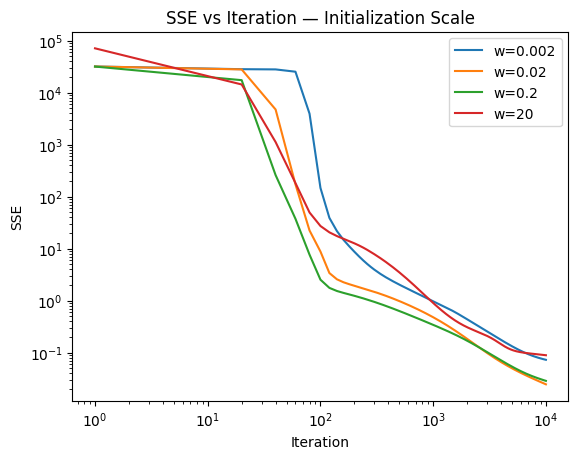

In [143]:
wscales = [0.002,0.02,0.2,20]
# hist_ws means history for different weight initialization scales
hist_ws = []
# labels_ws means labels for different weight initialization scales
labels_ws = []

for idx,ws in enumerate(wscales):
    h = train_run(P=P,T=T,S1_neurons=30,wscale=ws,alpha=0.01,Momentum_gamma=0.9,max_iters=max_iters,grad_tol=grad_tol,calculate_sse_after_iteration=calculate_sse_after_iteration,seed=300)
    hist_ws.append(h)
    labels_ws.append(f"w={ws}")

plt.figure()
for h,l in zip(hist_ws,labels_ws):
    x = np.array(h["iters"]); y = np.clip(np.array(h["SSE"]),1e-16,None)
    plt.loglog(x,y,label=l)
plt.xlabel("Iteration"); plt.ylabel("SSE"); plt.title("SSE vs Iteration — Initialization Scale"); plt.legend(); plt.show()

When we start from a relatively large initialization (relative with respect to our data), we end up with a larger SSE. That means a small value is preferred for initializing weights when momentum is activated. however, not too small. we want to avoid initializing at zero, and performance tends to be similar to the large-initialization case if the initial weights are too small (see the blue vs red line)

### Impact of different number of neurons on mid vs final snapshot during the training

W1 shape: (12, 1), b1 shape: (12, 1), W2 shape: (1, 12), b2 shape: (1, 1)


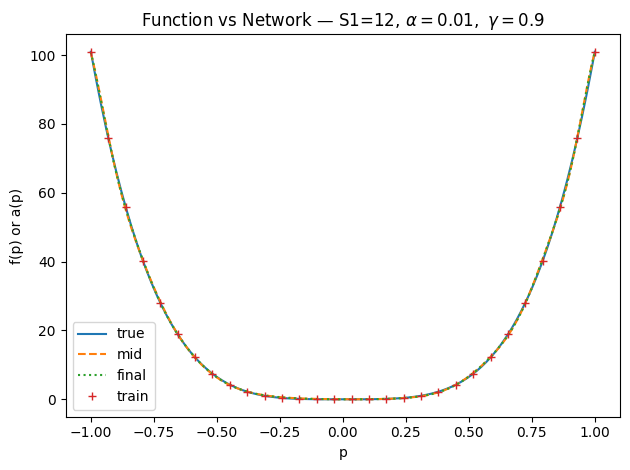

W1 shape: (240, 1), b1 shape: (240, 1), W2 shape: (1, 240), b2 shape: (1, 1)


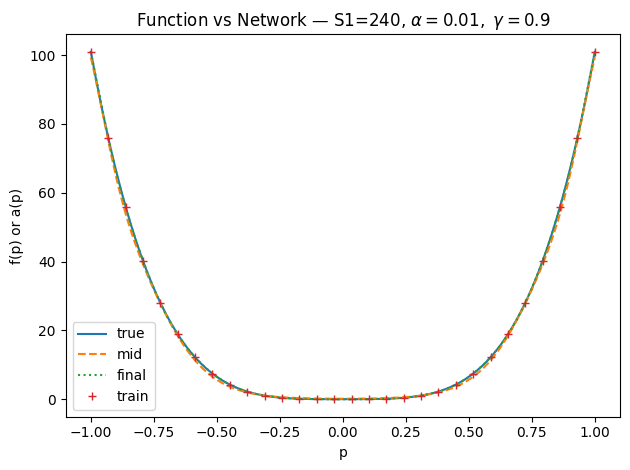

In [ ]:
h1 = train_run(P=P,T=T,S1_neurons=12,wscale=0.1,alpha=0.01,Momentum_gamma=0.9,max_iters=1500,grad_tol=grad_tol,calculate_sse_after_iteration=calculate_sse_after_iteration,seed=999)

W1m,b1m,W2m,b2m = h1["mid"]
W1f,b1f,W2f,b2f = h1["final"]
Amid = W2m@logsig(W1m@Pfine + b1m) + b2m
Afin = W2f@logsig(W1f@Pfine + b1f) + b2f

plt.figure()
plt.plot(Pfine.ravel(),Tf.ravel(),label="true")
plt.plot(Pfine.ravel(),Amid.ravel(),"--",label="mid")
plt.plot(Pfine.ravel(),Afin.ravel(),":",label="final")
plt.plot(P.ravel(),T.ravel(),"+",label="train")
# plt.xlim([-1/4,1/4])
# plt.ylim([-.02,1/4])
plt.xlabel("p"); plt.ylabel("f(p) or a(p)"); plt.title(f"Function vs Network — S1=12, $\\alpha={0.01},\\ \\gamma={0.9}$"); plt.legend();  plt.tight_layout(); plt.show()

h2 = train_run(P=P,T=T,S1_neurons=240,wscale=0.1,alpha=0.01,Momentum_gamma=0.9,max_iters=1500,grad_tol=grad_tol,calculate_sse_after_iteration=calculate_sse_after_iteration,seed=555)
W1m2,b1m2,W2m2,b2m2 = h2["mid"]
W1f2,b1f2,W2f2,b2f2 = h2["final"]
Amid2 = W2m2@logsig(W1m2@Pfine + b1m2) + b2m2
Afin2 = W2f2@logsig(W1f2@Pfine + b1f2) + b2f2

plt.figure()
plt.plot(Pfine.ravel(),Tf.ravel(),label="true")
plt.plot(Pfine.ravel(),Amid2.ravel(),"--",label="mid")
plt.plot(Pfine.ravel(),Afin2.ravel(),":",label="final")
plt.plot(P.ravel(),T.ravel(),"+",label="train")
plt.xlabel("p"); plt.ylabel("f(p) or a(p)"); plt.title(f"Function vs Network — S1=240, $\\alpha={0.01},\\ \\gamma={0.9}$"); plt.legend();  plt.tight_layout(); plt.show()

Assumptions: I reduced the number of iterations to 1500 to better show the mid-point effect.

If we have enough weights to represent the function, we can find the fit sooner (in terms of iterations) when we use fewer weights. This is reasonable because with more weights, we have to train more parameters, and it takes more iterations for all of them to reach the correct values—of course, in the presence of momentum. This conclusion can change if we have fewer neurons; for example, with 24 vs. 12 neurons, we might get a better mid-snap prediction at the same iteration count with 24 neurons.

In this case, we did not get overfitted results—which we would normally expect with more neurons—because of early stopping and the chosen function and momentum. I did not realize which one is the case here. 

### SSE numerical results:

In [ ]:


print("LR×Momentum results:")
for l,h in zip(labels_lrJ,hist_lrJ):
    print(l, "iters_last=",h["iters"][-1], "SSE_last=",h["SSE"][-1])

print("Hidden size results:")
for l,h in zip(labels_S1,hist_S1):
    print(l, "iters_last=",h["iters"][-1], "SSE_last=",h["SSE"][-1])

print("Init scale results:")
for l,h in zip(labels_ws,hist_ws):
    print(l, "iters_last=",h["iters"][-1], "SSE_last=",h["SSE"][-1])

LR×Momentum results:
$\alpha=1e-05,\ \gamma=0.0$ iters_last= 10000 SSE_last= 7398.571128836367
$\alpha=1e-05,\ \gamma=0.9$ iters_last= 10000 SSE_last= 7329.33388419459
$\alpha=0.01,\ \gamma=0.0$ iters_last= 10000 SSE_last= 5753.922622866984
$\alpha=0.01,\ \gamma=0.9$ iters_last= 10000 SSE_last= 0.04752552512180744
$\alpha=0.02,\ \gamma=0.0$ iters_last= 10000 SSE_last= 5062.100933402222
$\alpha=0.02,\ \gamma=0.9$ iters_last= 10000 SSE_last= 0.0935604374915133
Hidden size results:
S1=10 iters_last= 10000 SSE_last= 1002.4641862826713
S1=20 iters_last= 10000 SSE_last= 0.08565814482329918
S1=30 iters_last= 10000 SSE_last= 0.044458023044751924
Init scale results:
w=0.002 iters_last= 10000 SSE_last= 0.07263502429754463
w=0.02 iters_last= 10000 SSE_last= 0.02451878828395313
w=0.2 iters_last= 10000 SSE_last= 0.02857989020659394
w=20 iters_last= 10000 SSE_last= 0.08898418361477914


As we can see 1. we never met the gradient threshold. It might be larger than I tought. 2. Never converged when the learning rate was small. As I discussed this in the first part.   


## Summary of observations
1. Momentum generally makes SSE decrease more smoothly and reach the gradient threshold in fewer iterations compared to no momentum at the same learning rate.
2. Larger hidden sizes reduce approximation error but can slow optimization unless alpha and gamma are tuned; diminishing returns appear beyond moderate sizes.
3. Very small initial scales slow learning and very large ones can cause saturation; a middle range is usually best.
